I declare that this submission is my own work, and that I did not use any pretrained model or code that I did not explicitly cite.


In [1]:
# import libraries

# general libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# libraries for traing, testing, evaluating model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint



## Data Inspection


In [2]:
# Load data
data = np.load('dataset_dev_3000.npz')

# Explore keys
print("Keys:", data.files)

# Extract arrays
X = data['X']
y = data['y']

print("X shape:", X.shape)
print("y shape:", y.shape)


Keys: ['X', 'y']
X shape: (3000, 32, 32)
y shape: (3000, 3)


In [3]:
# Count number of samples per class
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")


Class 0.0: 387 samples
Class 0.00026430911384522915: 1 samples
Class 0.0012721653329208493: 1 samples
Class 0.001568699604831636: 1 samples
Class 0.001762773492373526: 1 samples
Class 0.0018284324323758483: 1 samples
Class 0.0019072487484663725: 1 samples
Class 0.0020356904715299606: 1 samples
Class 0.0021006499882787466: 1 samples
Class 0.0026393872685730457: 1 samples
Class 0.003119604429230094: 1 samples
Class 0.0033321119844913483: 1 samples
Class 0.0034062291961163282: 1 samples
Class 0.0035183411091566086: 1 samples
Class 0.003814652096480131: 1 samples
Class 0.003852665890008211: 1 samples
Class 0.003922072239220142: 1 samples
Class 0.004057707265019417: 1 samples
Class 0.004159008618444204: 1 samples
Class 0.004307989031076431: 1 samples
Class 0.0043214308097958565: 1 samples
Class 0.0043290406465530396: 1 samples
Class 0.0044805440120399: 1 samples
Class 0.005482145119458437: 1 samples
Class 0.00564561178907752: 1 samples
Class 0.005840257741510868: 1 samples
Class 0.005890033

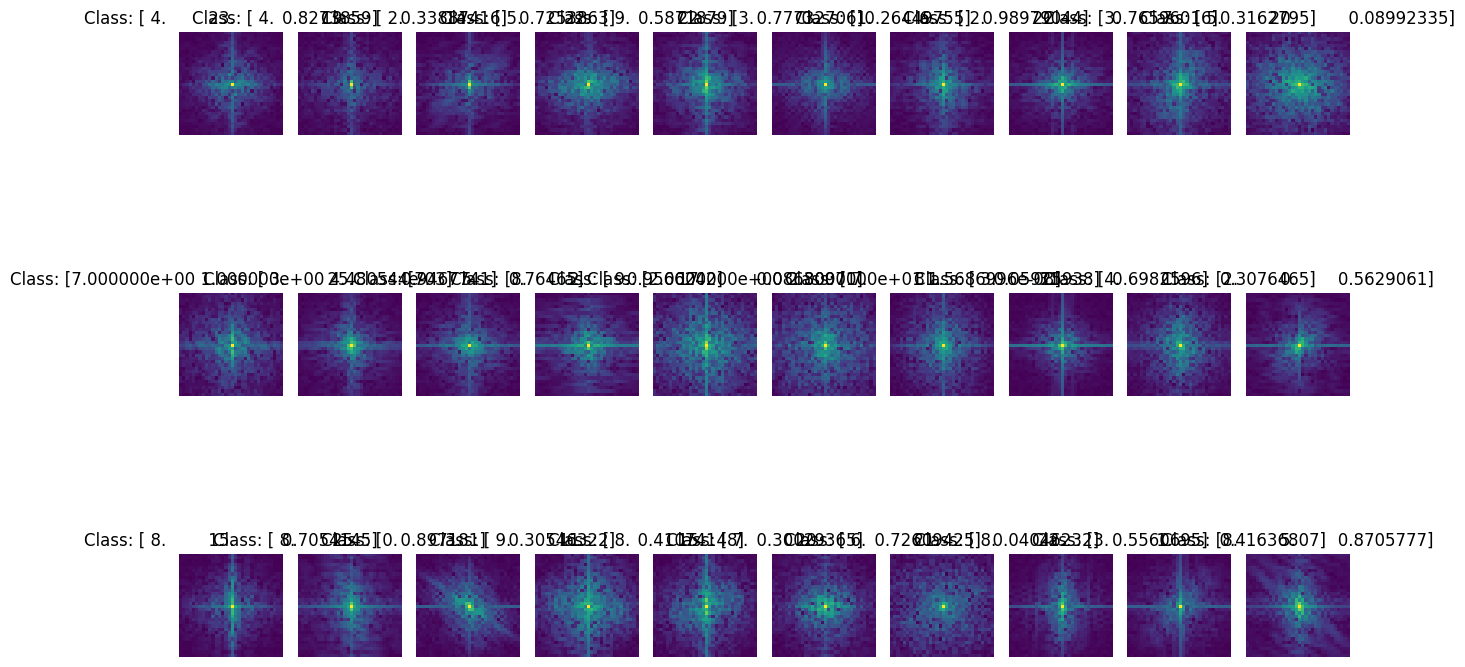

In [4]:
num_images = 30
rows = 3
cols = 10 

plt.figure(figsize=(12, 9))

# Pick 10 random indices
random_indices = np.random.choice(len(X), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[idx])
    plt.title(f"Class: {y[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing


In [5]:
# Normalize images
X = X.astype('float32') / 255.0

# Convert (16000, 32, 32) → (16000, 32, 32, 1)
X = X[..., np.newaxis]

y1 = y[:,0]              # Target A (0-9)
y2 = y[:,1]              # Target B (0-31)
y3 = y[:,2].astype('float32')  # Target C (regression)

y1_cat = to_categorical(y1, num_classes=10)  
y2_cat = to_categorical(y2, num_classes=32) 



In [6]:
X.shape

(3000, 32, 32, 1)

In [7]:
# Train test split at 80/20 ratio
X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
    X, y[:,0], y[:,1], y[:,2],
    test_size=0.2,
    random_state=42
)
print(X_train.shape, y1_train.shape, y2_train.shape, y3_train.shape)
print(X_test.shape, y1_test.shape, y2_test.shape, y3_test.shape)

(2400, 32, 32, 1) (2400,) (2400,) (2400,)
(600, 32, 32, 1) (600,) (600,) (600,)


## Data Augmentation


In [8]:
X_train, X_val, y1_train, y1_val, y2_train, y2_val, y3_train, y3_val = train_test_split(
    X_train, y1_train, y2_train, y3_train, test_size=0.2, random_state=42
)

# Create Dataset from NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((X_train, (y1_train, y2_train, y3_train)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, (y1_val, y2_val, y3_val)))

# Apply data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04),
    layers.RandomZoom(0.1),
])

def augment(x, y):
    x = data_augmentation(x)
    return x, y

train_ds = train_ds.map(augment).batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

## Architecture


In [14]:
from tensorflow.keras import layers

class LeNet(tf.keras.Model):
    def __init__(self, num_classes=(10,32,1)):
        super(LeNet, self).__init__()

        # Convolutional layers
        self.conv1 = layers.Conv2D(6, kernel_size=5, activation='tanh')
        self.pool1 = layers.AveragePooling2D(pool_size=2, strides=2)

        self.conv2 = layers.Conv2D(16, kernel_size=5, activation='tanh')
        self.pool2 = layers.AveragePooling2D(pool_size=2, strides=2)

        # Fully connected layers
        self.flatten = layers.Flatten()
        
        self.fc1 = layers.Dense(120, activation='tanh')
        self.fc2 = layers.Dense(84, activation='tanh')
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')

        self.fc1_2 = layers.Dense(120, activation='tanh')
        self.fc2_2 = layers.Dense(84, activation='tanh')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')

        self.fc1_3 = layers.Dense(120, activation='tanh')
        self.fc2_3 = layers.Dense(84, activation='tanh')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x_1 = self.fc1(x)
        x_1 = self.fc2(x)
        x_1 = self.output_layer_1(x)

        x_2 = self.fc1_2(x)
        x_2 = self.fc2_2(x)
        x_2 = self.output_layer_2(x)

        x_3 = self.fc1_3(x)
        x_3 = self.fc2_3(x)
        x_3 = self.output_layer_3(x)

        return (x_1, x_2, x_3)




In [15]:
from tensorflow.keras import layers, Model

class AlexNet(Model):
    def __init__(self, input_shape = (32, 32, 1), num_classes=(10,32,1)):
        super(AlexNet, self).__init__()

        # Layer 1
        self.conv1 = layers.Conv2D(48, (3, 3), strides=(1, 1), padding='same', input_shape=input_shape)
        self.relu1 = layers.Activation('relu')
        self.pool1 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn1 = layers.BatchNormalization()

        # Layer 2
        self.conv2 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu2 = layers.Activation('relu')
        self.pool2 = layers.MaxPooling2D((2, 2), strides=(2, 2))
        self.bn2 = layers.BatchNormalization()

        # Layer 3
        self.conv3 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu3 = layers.Activation('relu')

        # Layer 4
        self.conv4 = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same')
        self.relu4 = layers.Activation('relu')

        # Layer 5
        self.conv5 = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')
        self.relu5 = layers.Activation('relu')
        self.pool5 = layers.MaxPooling2D((2, 2), strides=(2, 2))

        # Fully connected layers
        self.flatten = layers.Flatten()

        self.fc1_1 = layers.Dense(512)
        self.relu_fc1_1 = layers.Activation('relu')
        self.dropout1_1 = layers.Dropout(0.5)

        self.fc2_1 = layers.Dense(256)
        self.relu_fc2_1 = layers.Activation('relu')
        self.dropout2_1 = layers.Dropout(0.5)

        self.fc1_2 = layers.Dense(512)
        self.relu_fc1_2 = layers.Activation('relu')
        self.dropout1_2 = layers.Dropout(0.5)

        self.fc2_2 = layers.Dense(256)
        self.relu_fc2_2 = layers.Activation('relu')
        self.dropout2_2 = layers.Dropout(0.5)

        self.fc1_3 = layers.Dense(512)
        self.relu_fc1_3 = layers.Activation('relu')
        self.dropout1_3 = layers.Dropout(0.5)

        self.fc2_3 = layers.Dense(256)
        self.relu_fc2_3 = layers.Activation('relu')
        self.dropout2_3 = layers.Dropout(0.5)


        # Output layer
        self.output_layer_1 = layers.Dense(num_classes[0], activation='softmax')
        self.output_layer_2 = layers.Dense(num_classes[1], activation='softmax')
        self.output_layer_3 = layers.Dense(num_classes[2], activation='sigmoid')

    def call(self, x, training=False):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.bn1(x, training=training)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.bn2(x, training=training)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)

        # Layer 4
        x = self.conv4(x)
        x = self.relu4(x)

        # Layer 5
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool5(x)

        # Flatten
        x = self.flatten(x)

        # First path
        x_1 = self.fc1_1(x)
        x_1 = self.relu_fc1_1(x_1)
        x_1 = self.dropout1_1(x_1, training=training)

        x_1 = self.fc2_1(x_1)
        x_1 = self.relu_fc2_1(x_1)
        x_1 = self.dropout2_1(x_1, training=training)
        output_1 = self.output_layer_1(x_1)

        # Second path
        x_2 = self.fc1_2(x)
        x_2 = self.relu_fc1_2(x_2)
        x_2 = self.dropout1_2(x_2, training=training)

        x_2 = self.fc2_2(x_2)
        x_2 = self.relu_fc2_2(x_2)
        x_2 = self.dropout2_2(x_2, training=training)
        output_2 = self.output_layer_2(x_2)

        # Third path
        x_3 = self.fc1_3(x)
        x_3 = self.relu_fc1_3(x_3)
        x_3 = self.dropout1_3(x_3, training=training)

        x_3 = self.fc2_3(x_3)
        x_3 = self.relu_fc2_3(x_3)
        x_3 = self.dropout2_3(x_3, training=training)
        output_3 = self.output_layer_3(x_3)


        # Output
        return (output_1, output_2, output_3)


In [16]:
optimizer = Adam(learning_rate=0.0001) 

model = LeNet()
model.compile(
    optimizer=optimizer,
    loss=[
        'sparse_categorical_crossentropy',
        'sparse_categorical_crossentropy',
        'mse'
    ],
    metrics=[
        ['accuracy'],
        ['accuracy'],
        ['mse']
    ]
)
model.build(input_shape=(None, 32, 32, 1))

c:\Users\Admin\Desktop\DL\DL-ASM2\.venv\Lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'le_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [17]:
# dummy_input = tf.random.normal((1, 32, 32, 1))
# model(dummy_input)
# model.summary()

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model based on Target A (first output) validation accuracy
checkpoint = ModelCheckpoint(
    filepath='model_s3759957.h5',
    monitor='val_output_1_accuracy',  # monitor the first output's accuracy
    save_best_only=True,
    mode='max',
    verbose=1
)

# Training
history = model.fit(
    train_ds,          # tf.data.Dataset for training (X, (y1, y2, y3))
    validation_data=val_ds,  # tf.data.Dataset for validation
    epochs=30,
    verbose=1,
    callbacks=[checkpoint]
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1667 - accuracy_1: 0.0502 - loss: 5.7403 - mse: 0.0699 - mse_loss: 0.0699 - sparse_categorical_crossentropy_loss: 3.4503

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1708 - accuracy_1: 0.0510 - loss: 5.7379 - mse: 0.0685 - mse_loss: 0.0685 - sparse_categorical_crossentropy_loss: 3.4486 - val_accuracy: 0.1604 - val_accuracy_1: 0.0333 - val_loss: 5.7973 - val_mse: 0.0770 - val_mse_loss: 0.0770 - val_sparse_categorical_crossentropy_loss: 3.4762
Epoch 2/30
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1738 - accuracy_1: 0.0501 - loss: 5.7271 - mse: 0.0706 - mse_loss: 0.0706 - sparse_categorical_crossentropy_loss: 3.4450 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1781 - accuracy_1: 0.0474 - loss: 5.7312 - mse: 0.0688 - mse_loss: 0.0688 - sparse_categorical_crossentropy_loss: 3.4464 - val_accuracy: 0.1667 - val_accuracy_1: 0.0375 - val_loss: 5.7901 - val_mse: 0.0764 - val_mse_loss: 0.0764 - val_sparse_categorical_crossentropy_loss: 3.4771
Epoch 3/30
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1901 - accuracy_1: 0.0476 - loss: 5.7394 - mse: 0.0667 - mse_loss: 0.0667 - sparse_categorical_crossentropy_loss: 3.4473 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1839 - accuracy_1: 0.0500 - loss: 5.7298 - mse: 0.0695 - mse_loss: 0.0695 - sparse_categorical_crossentropy_loss: 3.4473 - val_accuracy: 0.1771 - val_accuracy_1: 0.0333 - val_loss: 5.8050 - val_mse: 0.0746 - val_mse_loss: 0.0746 - val_sparse_categorical_crossentropy_loss: 3.4821
Epoch 4/30
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1760 - accuracy_1: 0.0480 - loss: 5.7402 - mse: 0.0678 - mse_loss: 0.0678 - sparse_categorical_crossentropy_loss: 3.4510 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1854 - accuracy_1: 0.0495 - loss: 5.7281 - mse: 0.0699 - mse_loss: 0.0699 - sparse_categorical_crossentropy_loss: 3.4462 - val_accuracy: 0.1646 - val_accuracy_1: 0.0333 - val_loss: 5.7802 - val_mse: 0.0777 - val_mse_loss: 0.0777 - val_sparse_categorical_crossentropy_loss: 3.4736
Epoch 5/30
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1848 - accuracy_1: 0.0605 - loss: 5.7198 - mse: 0.0687 - mse_loss: 0.0687 - sparse_categorical_crossentropy_loss: 3.4399

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1922 - accuracy_1: 0.0521 - loss: 5.7215 - mse: 0.0677 - mse_loss: 0.0677 - sparse_categorical_crossentropy_loss: 3.4467 - val_accuracy: 0.1667 - val_accuracy_1: 0.0333 - val_loss: 5.7916 - val_mse: 0.0764 - val_mse_loss: 0.0764 - val_sparse_categorical_crossentropy_loss: 3.4771
Epoch 6/30
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1899 - accuracy_1: 0.0522 - loss: 5.7189 - mse: 0.0685 - mse_loss: 0.0685 - sparse_categorical_crossentropy_loss: 3.4421 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1922 - accuracy_1: 0.0526 - loss: 5.7225 - mse: 0.0696 - mse_loss: 0.0696 - sparse_categorical_crossentropy_loss: 3.4462 - val_accuracy: 0.1833 - val_accuracy_1: 0.0354 - val_loss: 5.7852 - val_mse: 0.0759 - val_mse_loss: 0.0759 - val_sparse_categorical_crossentropy_loss: 3.4790
Epoch 7/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1657 - accuracy_1: 0.0531 - loss: 5.7214 - mse: 0.0716 - mse_loss: 0.0716 - sparse_categorical_crossentropy_loss: 3.4398 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1776 - accuracy_1: 0.0516 - loss: 5.7188 - mse: 0.0700 - mse_loss: 0.0700 - sparse_categorical_crossentropy_loss: 3.4457 - val_accuracy: 0.1813 - val_accuracy_1: 0.0292 - val_loss: 5.7872 - val_mse: 0.0739 - val_mse_loss: 0.0739 - val_sparse_categorical_crossentropy_loss: 3.4727
Epoch 8/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1856 - accuracy_1: 0.0519 - loss: 5.7156 - mse: 0.0666 - mse_loss: 0.0666 - sparse_categorical_crossentropy_loss: 3.4414 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1891 - accuracy_1: 0.0516 - loss: 5.7200 - mse: 0.0681 - mse_loss: 0.0681 - sparse_categorical_crossentropy_loss: 3.4452 - val_accuracy: 0.1813 - val_accuracy_1: 0.0292 - val_loss: 5.7898 - val_mse: 0.0749 - val_mse_loss: 0.0749 - val_sparse_categorical_crossentropy_loss: 3.4790
Epoch 9/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1641 - accuracy_1: 0.0497 - loss: 5.7239 - mse: 0.0667 - mse_loss: 0.0667 - sparse_categorical_crossentropy_loss: 3.4470 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1833 - accuracy_1: 0.0505 - loss: 5.7116 - mse: 0.0679 - mse_loss: 0.0679 - sparse_categorical_crossentropy_loss: 3.4446 - val_accuracy: 0.1729 - val_accuracy_1: 0.0333 - val_loss: 5.7831 - val_mse: 0.0744 - val_mse_loss: 0.0744 - val_sparse_categorical_crossentropy_loss: 3.4776
Epoch 10/30
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1959 - accuracy_1: 0.0540 - loss: 5.7033 - mse: 0.0687 - mse_loss: 0.0687 - sparse_categorical_crossentropy_loss: 3.4386 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1995 - accuracy_1: 0.0464 - loss: 5.7042 - mse: 0.0684 - mse_loss: 0.0684 - sparse_categorical_crossentropy_loss: 3.4436 - val_accuracy: 0.1896 - val_accuracy_1: 0.0375 - val_loss: 5.7798 - val_mse: 0.0747 - val_mse_loss: 0.0747 - val_sparse_categorical_crossentropy_loss: 3.4768
Epoch 11/30
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1929 - accuracy_1: 0.0583 - loss: 5.7012 - mse: 0.0649 - mse_loss: 0.0649 - sparse_categorical_crossentropy_loss: 3.4393 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1823 - accuracy_1: 0.0500 - loss: 5.7048 - mse: 0.0669 - mse_loss: 0.0669 - sparse_categorical_crossentropy_loss: 3.4430 - val_accuracy: 0.1896 - val_accuracy_1: 0.0271 - val_loss: 5.7792 - val_mse: 0.0754 - val_mse_loss: 0.0754 - val_sparse_categorical_crossentropy_loss: 3.4805
Epoch 12/30
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1882 - accuracy_1: 0.0521 - loss: 5.7062 - mse: 0.0665 - mse_loss: 0.0665 - sparse_categorical_crossentropy_loss: 3.4436 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1969 - accuracy_1: 0.0542 - loss: 5.7033 - mse: 0.0679 - mse_loss: 0.0679 - sparse_categorical_crossentropy_loss: 3.4441 - val_accuracy: 0.1729 - val_accuracy_1: 0.0333 - val_loss: 5.7953 - val_mse: 0.0752 - val_mse_loss: 0.0752 - val_sparse_categorical_crossentropy_loss: 3.4798
Epoch 13/30
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1876 - accuracy_1: 0.0505 - loss: 5.7136 - mse: 0.0669 - mse_loss: 0.0669 - sparse_categorical_crossentropy_loss: 3.4495 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1865 - accuracy_1: 0.0526 - loss: 5.7040 - mse: 0.0675 - mse_loss: 0.0675 - sparse_categorical_crossentropy_loss: 3.4435 - val_accuracy: 0.1729 - val_accuracy_1: 0.0271 - val_loss: 5.7820 - val_mse: 0.0764 - val_mse_loss: 0.0764 - val_sparse_categorical_crossentropy_loss: 3.4779
Epoch 14/30
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2138 - accuracy_1: 0.0497 - loss: 5.7011 - mse: 0.0665 - mse_loss: 0.0665 - sparse_categorical_crossentropy_loss: 3.4491 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1891 - accuracy_1: 0.0531 - loss: 5.7062 - mse: 0.0670 - mse_loss: 0.0670 - sparse_categorical_crossentropy_loss: 3.4430 - val_accuracy: 0.1833 - val_accuracy_1: 0.0292 - val_loss: 5.7808 - val_mse: 0.0750 - val_mse_loss: 0.0750 - val_sparse_categorical_crossentropy_loss: 3.4819
Epoch 15/30
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1955 - accuracy_1: 0.0569 - loss: 5.6890 - mse: 0.0652 - mse_loss: 0.0652 - sparse_categorical_crossentropy_loss: 3.4384 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1891 - accuracy_1: 0.0526 - loss: 5.7046 - mse: 0.0676 - mse_loss: 0.0676 - sparse_categorical_crossentropy_loss: 3.4423 - val_accuracy: 0.1833 - val_accuracy_1: 0.0354 - val_loss: 5.7736 - val_mse: 0.0742 - val_mse_loss: 0.0742 - val_sparse_categorical_crossentropy_loss: 3.4791
Epoch 16/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1809 - accuracy_1: 0.0526 - loss: 5.7062 - mse: 0.0668 - mse_loss: 0.0668 - sparse_categorical_crossentropy_loss: 3.4419     

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1943 - accuracy_1: 0.0521 - loss: 5.6988 - mse: 0.0671 - mse_loss: 0.0671 - sparse_categorical_crossentropy_loss: 3.4430 - val_accuracy: 0.2000 - val_accuracy_1: 0.0229 - val_loss: 5.7702 - val_mse: 0.0734 - val_mse_loss: 0.0734 - val_sparse_categorical_crossentropy_loss: 3.4742
Epoch 17/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1975 - accuracy_1: 0.0512 - loss: 5.7051 - mse: 0.0658 - mse_loss: 0.0658 - sparse_categorical_crossentropy_loss: 3.4405 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1979 - accuracy_1: 0.0510 - loss: 5.6976 - mse: 0.0666 - mse_loss: 0.0666 - sparse_categorical_crossentropy_loss: 3.4430 - val_accuracy: 0.1979 - val_accuracy_1: 0.0312 - val_loss: 5.7702 - val_mse: 0.0742 - val_mse_loss: 0.0742 - val_sparse_categorical_crossentropy_loss: 3.4759
Epoch 18/30
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1693 - accuracy_1: 0.0545 - loss: 5.7090 - mse: 0.0643 - mse_loss: 0.0643 - sparse_categorical_crossentropy_loss: 3.4390 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1958 - accuracy_1: 0.0500 - loss: 5.6980 - mse: 0.0659 - mse_loss: 0.0659 - sparse_categorical_crossentropy_loss: 3.4432 - val_accuracy: 0.1750 - val_accuracy_1: 0.0333 - val_loss: 5.7791 - val_mse: 0.0743 - val_mse_loss: 0.0743 - val_sparse_categorical_crossentropy_loss: 3.4755
Epoch 19/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1869 - accuracy_1: 0.0528 - loss: 5.7072 - mse: 0.0637 - mse_loss: 0.0637 - sparse_categorical_crossentropy_loss: 3.4455 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1906 - accuracy_1: 0.0500 - loss: 5.6951 - mse: 0.0662 - mse_loss: 0.0662 - sparse_categorical_crossentropy_loss: 3.4420 - val_accuracy: 0.1833 - val_accuracy_1: 0.0354 - val_loss: 5.7719 - val_mse: 0.0747 - val_mse_loss: 0.0747 - val_sparse_categorical_crossentropy_loss: 3.4739
Epoch 20/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2279 - accuracy_1: 0.0548 - loss: 5.6738 - mse: 0.0658 - mse_loss: 0.0658 - sparse_categorical_crossentropy_loss: 3.4404 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2094 - accuracy_1: 0.0521 - loss: 5.6921 - mse: 0.0663 - mse_loss: 0.0663 - sparse_categorical_crossentropy_loss: 3.4418 - val_accuracy: 0.1917 - val_accuracy_1: 0.0250 - val_loss: 5.7750 - val_mse: 0.0720 - val_mse_loss: 0.0720 - val_sparse_categorical_crossentropy_loss: 3.4776
Epoch 21/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1926 - accuracy_1: 0.0468 - loss: 5.7026 - mse: 0.0673 - mse_loss: 0.0673 - sparse_categorical_crossentropy_loss: 3.4522     

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2047 - accuracy_1: 0.0547 - loss: 5.6901 - mse: 0.0653 - mse_loss: 0.0653 - sparse_categorical_crossentropy_loss: 3.4426 - val_accuracy: 0.1792 - val_accuracy_1: 0.0375 - val_loss: 5.7673 - val_mse: 0.0724 - val_mse_loss: 0.0724 - val_sparse_categorical_crossentropy_loss: 3.4777
Epoch 22/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2183 - accuracy_1: 0.0582 - loss: 5.6811 - mse: 0.0663 - mse_loss: 0.0663 - sparse_categorical_crossentropy_loss: 3.4494     

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2146 - accuracy_1: 0.0547 - loss: 5.6869 - mse: 0.0657 - mse_loss: 0.0657 - sparse_categorical_crossentropy_loss: 3.4420 - val_accuracy: 0.2062 - val_accuracy_1: 0.0333 - val_loss: 5.7657 - val_mse: 0.0714 - val_mse_loss: 0.0714 - val_sparse_categorical_crossentropy_loss: 3.4718
Epoch 23/30
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2224 - accuracy_1: 0.0498 - loss: 5.6858 - mse: 0.0658 - mse_loss: 0.0658 - sparse_categorical_crossentropy_loss: 3.4368 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1974 - accuracy_1: 0.0464 - loss: 5.6980 - mse: 0.0662 - mse_loss: 0.0662 - sparse_categorical_crossentropy_loss: 3.4428 - val_accuracy: 0.1896 - val_accuracy_1: 0.0333 - val_loss: 5.7689 - val_mse: 0.0717 - val_mse_loss: 0.0717 - val_sparse_categorical_crossentropy_loss: 3.4771
Epoch 24/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1935 - accuracy_1: 0.0444 - loss: 5.6956 - mse: 0.0658 - mse_loss: 0.0658 - sparse_categorical_crossentropy_loss: 3.4437     

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1984 - accuracy_1: 0.0552 - loss: 5.6856 - mse: 0.0652 - mse_loss: 0.0652 - sparse_categorical_crossentropy_loss: 3.4397 - val_accuracy: 0.2146 - val_accuracy_1: 0.0312 - val_loss: 5.7769 - val_mse: 0.0725 - val_mse_loss: 0.0725 - val_sparse_categorical_crossentropy_loss: 3.4784
Epoch 25/30
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2164 - accuracy_1: 0.0561 - loss: 5.6927 - mse: 0.0631 - mse_loss: 0.0631 - sparse_categorical_crossentropy_loss: 3.4424 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2036 - accuracy_1: 0.0505 - loss: 5.6856 - mse: 0.0650 - mse_loss: 0.0650 - sparse_categorical_crossentropy_loss: 3.4417 - val_accuracy: 0.1875 - val_accuracy_1: 0.0271 - val_loss: 5.7542 - val_mse: 0.0730 - val_mse_loss: 0.0730 - val_sparse_categorical_crossentropy_loss: 3.4776
Epoch 26/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1942 - accuracy_1: 0.0547 - loss: 5.6725 - mse: 0.0660 - mse_loss: 0.0660 - sparse_categorical_crossentropy_loss: 3.4331 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2036 - accuracy_1: 0.0536 - loss: 5.6790 - mse: 0.0646 - mse_loss: 0.0646 - sparse_categorical_crossentropy_loss: 3.4389 - val_accuracy: 0.1833 - val_accuracy_1: 0.0292 - val_loss: 5.7757 - val_mse: 0.0726 - val_mse_loss: 0.0726 - val_sparse_categorical_crossentropy_loss: 3.4791
Epoch 27/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2111 - accuracy_1: 0.0540 - loss: 5.6752 - mse: 0.0645 - mse_loss: 0.0645 - sparse_categorical_crossentropy_loss: 3.4319 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2094 - accuracy_1: 0.0484 - loss: 5.6832 - mse: 0.0653 - mse_loss: 0.0653 - sparse_categorical_crossentropy_loss: 3.4393 - val_accuracy: 0.1917 - val_accuracy_1: 0.0229 - val_loss: 5.7753 - val_mse: 0.0725 - val_mse_loss: 0.0725 - val_sparse_categorical_crossentropy_loss: 3.4812
Epoch 28/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1832 - accuracy_1: 0.0452 - loss: 5.6945 - mse: 0.0640 - mse_loss: 0.0640 - sparse_categorical_crossentropy_loss: 3.4482     

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1995 - accuracy_1: 0.0479 - loss: 5.6794 - mse: 0.0649 - mse_loss: 0.0649 - sparse_categorical_crossentropy_loss: 3.4383 - val_accuracy: 0.1937 - val_accuracy_1: 0.0333 - val_loss: 5.7739 - val_mse: 0.0715 - val_mse_loss: 0.0715 - val_sparse_categorical_crossentropy_loss: 3.4751
Epoch 29/30
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2213 - accuracy_1: 0.0389 - loss: 5.6636 - mse: 0.0613 - mse_loss: 0.0613 - sparse_categorical_crossentropy_loss: 3.4331 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2151 - accuracy_1: 0.0443 - loss: 5.6738 - mse: 0.0638 - mse_loss: 0.0638 - sparse_categorical_crossentropy_loss: 3.4403 - val_accuracy: 0.2167 - val_accuracy_1: 0.0333 - val_loss: 5.7711 - val_mse: 0.0719 - val_mse_loss: 0.0719 - val_sparse_categorical_crossentropy_loss: 3.4805
Epoch 30/30
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2175 - accuracy_1: 0.0576 - loss: 5.6840 - mse: 0.0655 - mse_loss: 0.0655 - sparse_categorical_crossentropy_loss: 3.4350 

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2214 - accuracy_1: 0.0526 - loss: 5.6773 - mse: 0.0647 - mse_loss: 0.0647 - sparse_categorical_crossentropy_loss: 3.4398 - val_accuracy: 0.2042 - val_accuracy_1: 0.0333 - val_loss: 5.7559 - val_mse: 0.0703 - val_mse_loss: 0.0703 - val_sparse_categorical_crossentropy_loss: 3.4776
